In [1]:
import Pkg; Pkg.activate(joinpath(@__DIR__,".")); Pkg.instantiate();
using LinearAlgebra;
using Plots;
using StaticArrays;
using ForwardDiff;
using RobotZoo;
using RobotDynamics;
using MeshCat;
using TrajOptPlots;
using MathOptInterface;
const MOI = MathOptInterface
using Ipopt;
using RigidBodyDynamics;
using Symbolics;

 Activating environment at `C:\Users\brand\OneDrive\Documents\College Stuff\16-745\final-project\Project.toml`


We know the dynamics are of the following:
            $$q = \begin{bmatrix}
                  x_{foot}    \\
                  y_{foot}   \\
                  \alpha \\
                  \beta  \\
                  \end{bmatrix}$$
where $\alpha$ is the top revolute joint and $\beta$ is the middle revolute joint
And normally for a single dynamics phase,
$$ dx = \delta_{(x, 1)} f_{1}(x, u) + \delta_{(x, 2)} f_{2}(x, u)$$

which is pretty much a guard function.

           
           
           
           
           

In [2]:
struct Hopper
    ml
    l
    function Hopper(ml, l)
        new(ml, l)
    end
end


h = 0.05
g = 9.81
m1 = 1.0
m2 = 1.0
ℓ1 = 1.0
ℓ2 = 1.0
J1 = (1.0/12)*m1*ℓ1*ℓ1
J2 = (1.0/12)*m2*ℓ2*ℓ2


function link2_kinematics(q)
    x1 = q[1]
    y1 = q[2]
    θ1 = q[3]
    θ2 = q[4]
    
    x2 = x1 - 0.5*ℓ1*sin(θ1) - 0.5*ℓ2*sin(θ2)
    y2 = y1 + 0.5*ℓ1*cos(θ1) + 0.5*ℓ2*cos(θ2)
    
    return [x2; y2]
end

function foot_kinematics(q)
    x1 = q[1]
    y1 = q[2]
    θ1 = q[3]
    
    xf = x1 + 0.5*ℓ1*sin(θ1)
    yf = y1 - 0.5*ℓ1*cos(θ1)
    
    return [xf; yf]
end



#Fast Kinematics Functions

@variables q[1:4]
@variables q̇[1:4]
@variables u[1:2] #torque inputs on links 1 and 2
@variables f[1:2] #contact force on foot (end of link 1)

klink2 = link2_kinematics(q)
klink2_expr = Symbolics.build_function(klink2, q)
k2_func = eval(klink2_expr[1])

kfoot = foot_kinematics(q)
kfoot_expr = Symbolics.build_function(kfoot, q)
kfoot_func = eval(kfoot_expr[1])

#Kinematics Jacobians

J2 = Symbolics.jacobian(klink2, q, simplify = true)
Jf = Symbolics.jacobian(kfoot, q, simplify = true)

J2_expr = Symbolics.build_function(J2, q)
Jf_expr = Symbolics.build_function(Jf, q)

J2_func = eval(J2_expr[1])
Jf_func = eval(Jf_expr[1])

#Lagrangian
function lagrangian(q, q̇)
    L = 0.0

    # Link 1
    v1 = 
    L += 0.5*m1*transpose(q̇[1:2])*q̇[1:2] + 0.5*J1*q̇[3]*q̇[3] #kinetic energy
    L -= m1*g*q[2] #potential energy

    # Link 2
    v2 = J2_func(q)*q̇
    L += 0.5*m2*transpose(v2)*v2
    L -= m2*g*k2_func(q)[2]

    return L
end

L = lagrangian(q, q̇)
dLq = Symbolics.gradient(L, q, simplify = true)
dLq̇ = Symbolics.gradient(L, q̇, simplify = true)
d2L = Symbolics.hessian(L, [q; q̇], simplify = true)

#mass matrix
M = d2L[4 .+ (1:4), 4 .+ (1:4)]
M = simplify.(M)

#dynamics bias
C = d2L[4 .+ (1:4), 1:4] * q̇ - dLq
C = simplify.(C)

#input jacobian
B = [0.0 0.0; 0.0 0.0; 1.0 0.0; 0.0 1.0]

# continuous-time dynamics
ẋ = [q̇; M\(B*u + transpose(Jf)*f - C)]
ẋ = simplify.(ẋ)

ẋ_expr = Symbolics.build_function(ẋ, [q; q̇], u, f)

dynamics = eval(ẋ_expr[1])

# continuous-time dynamics derivatives

dẋ = Symbolics.jacobian(ẋ, [q; q̇; u; f]);
dx = simplify(dẋ[:,1:8])
du = simplify(dẋ[:,9:10])
df = simplify(dẋ[:,11:12])

Ac_expr = Symbolics.build_function(dx, [q; q̇], u, f)
Bc_expr = Symbolics.build_function(du, [q; q̇], u, f)
Cc_expr = Symbolics.build_function(df, [q; q̇], u, f)

Ac = eval(Ac_expr[1])
Bc = eval(Bc_expr[1])
Cc = eval(Cc_expr[1])

#Discrete-time dynamics with foot pinned at the origin
function implicit_euler(x,u; inair=false)
    xn = x
    f = zeros(2)
    if inair
        r = xn - x - h.*dynamics(xn,u,f)
    else
        r = [xn - x - h.*dynamics(xn,u,f); foot_kinematics(xn)]
    end
   #  println(r)
    
    while maximum(abs.(r)) > 1e-6
        if inair
            dr = I-h.*Ac(xn,u,f)
            # println(size(dr))
            dx = -dr\r
            xn += dx
            r = xn - x - h.*dynamics(xn,u,f)
        else
            dr = [I-h.*Ac(xn,u,f) -h.*Cc(xn,u,f); Jf_func(xn[1:4]) zeros(2,6)]
            dz = -dr\r
            xn += dz[1:8]
            f += dz[9:10]
            r = [xn - x - h.*dynamics(xn,u,f); foot_kinematics(xn)]
        end
    end
    
    return xn
end

function num_duals(nlp)
    return nlp.cinds[end][end]
end


function num_primals(nlp)
    return nlp.N*8 + (nlp.N - 1)*2
end


function jump_map(x)
    return [x[1:4]; 0.0; 0.0; x[7:8]]
end

jump_map (generic function with 1 method)

[0.0, -0.02452500000000002]
[0.0, -0.073575]
[0.0, -0.14715]
[0.0, -0.24525000000000002]
[0.0, -0.36787500000000006]
[0.0, -0.5150250000000001]
[0.0, -0.6867000000000001]
[0.0, -0.8829]
[0.0, -1.103625]
[0.0, -1.348875]
[0.0, -1.6186500000000001]
[0.0, -1.9129500000000002]
[0.0, -2.2317750000000003]
[0.0, -2.5751250000000003]
[0.0, -2.9430000000000005]
[0.0, -3.3354000000000004]
[0.0, -3.7523250000000004]
[0.0, -4.1937750000000005]
[0.0, -4.659750000000001]
[0.0, -5.150250000000001]
[0.0, -5.665275000000001]
[0.0, -6.204825000000001]
[0.0, -6.768900000000001]
[0.0, -7.357500000000002]
[0.0, -7.970625000000002]
[0.0, -8.608275]
[0.0, -9.27045]
[0.0, -9.95715]
[0.0, -10.668375000000001]
[0.0, -11.404125000000002]
[0.0, -12.164400000000002]
[0.0, -12.949200000000003]
[0.0, -13.758525000000004]
[0.0, -14.592375000000004]
[0.0, -15.450750000000005]
[0.0, -16.333650000000006]
[0.0, -17.241075000000006]
[0.0, -18.173025000000006]
[0.0, -19.129500000000007]


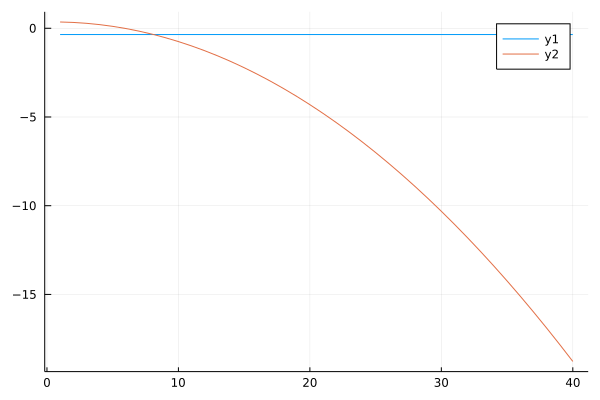

In [3]:
# Test the foot coords. The description for both is from the vertical
begin
    l = 1.0
    t1 = pi/4
    t2 = -pi/4
    x0 = [-l/2*sin(t1); l/2*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    # println(x0)
    hopper = Hopper(1, 1)
    # fx = foot_coords(hopper, x0)
    h = 0.05
    # regCoords = foot_coords(hopper, fx)
    # println(fx)
    u = [0.0; 0.0]
    λ = [0.0; 0.0]
    ts = 40
    x = x0
    xVals = zeros(ts, length(x))
    xVals[1, :] .= x0
    for i = 2:ts
        newX = implicit_euler(x, u, inair=true)
        # λ = newL
        x = newX
        xVals[i, :] .= x
        # println(x)
        # println(λ)
        println(kfoot_func(x))
    end
    # println(xVals[end, :])
    # plot(xVals[:, 1], xVals[:, 2])
    # println(xVals[end, 2])
    plot(1:ts, xVals[:, 1])
    plot!(1:ts, xVals[:, 2])
    # plot!(1:ts, xVals[:, 5])
    
end

# Controls Part: Solving an NLP using IPOPT
We want to formulate the problem as follows:
$$ min_{z=1:N} \frac{1}{2}(z_{N}-z_{N, ref})^{T} Q_{N} (z_{N}-z_{N, ref}) + \sum \frac{1}{2}(z_{n}-z_{n, ref})^{T} Q_{n} (z_{n}-z_{n, ref}) + q_{n}^{T}(z_{n}-z_{n, ref})$$ 
where the combined $$ z = \begin{bmatrix} u_{1} \\ x_{2} \\ u_{2} \\ . \\ .\\ . \\ x_{N} \end{bmatrix}$$

To do this, we need to solve for the piece $c(z)$. The solver (IPOPT) should handle the rest for us.

$$c(z) = \begin{bmatrix} c_{dyn}\\ c_{\alpha} \\ c_{>0} \\ c_{y_{nref}} \\ c_{init} \\ c_{term}\end{bmatrix}$$
  
where
$$c_{>0} \rightarrow{} y_{ref} = 0 \text{ (in stance mode)}$$
$$c_{\alpha} \rightarrow{} \frac{\pi}{2} \leq \alpha \leq \pi$$
$$c_{y_{nref}} \rightarrow {} y_{nref} > y_{ref} $$
$c_{dyn}$ is the usual dynamics equality constraint

In [4]:
# Some useful functions
# Find the LQR cost of something
function LQRcost(nlp, Z)
    J = 0.0
    xinds, uinds = nlp.xinds, nlp.uinds
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    uf = zeros(length(U[1]))
    # Some useful constants
    c = 0.5*xf'*Q*xf + 0.5*uf'*R*uf
    q = -Q*xf
    r = -R*uf
    for i = 1:nlp.N-1
        x = Z[xinds[i]]
        u = Z[uinds[i]]
        # Stage cost
        J += 0.5*(x'*Q*x + u'*R*u) + q'*x + r'*u + c
    end
    x = Z[xinds[end]]
    # Terminal cost
    J += 0.5*x'*Qf*x + q'*x + c
    return J
end


function cost_grad!(nlp, grad, Z)
    xinds, uinds = nlp.xinds, nlp.uinds
    Q = nlp.Q
    R = nlp.R
    Q = nlp.Q
    Qf = nlp.Qf
    xf = nlp.xf
    N = nlp.N
    uf = zeros(length(uinds[1]))
    # Some useful constants
    q = -Q*xf
    r = -R*uf
    for i = 1:N-1
        x, u = Z[xinds[i]], Z[uinds[i]]
        grad[xinds[i]] .= Q*x + q
        grad[uinds[i]] .= R*u + r
    end
    grad[xinds[end]] .= Qf*Z[xinds[end]] + q
    return nothing
end
    

function unpack(nlp, Z)
    # println(size(Z))
    X = [Z[inds] for inds in nlp.xinds]
    U = [Z[inds] for inds in nlp.uinds]
    # λ = [Z[inds] for inds in nlp.linds]
    return X, U
end



function pack(nlp, X, U)
    # println(nlp.N)
    # println(λ)
    Z = zeros(nlp.N*length(X[1]) + (nlp.N - 1)*length(U[1]))
    # println(length(Z))
    for i = 1:nlp.N-1
        Z[nlp.xinds[i]] .= X[i]
        Z[nlp.uinds[i]] .= U[i]
        # Z[nlp.linds[i]] .= λ[i]
    end
    Z[nlp.xinds[end]] .= X[end]
    # Z[nlp.linds[end]] .= λ[end]
    return Z
end
        
        

# First, we want to define the problem. The length of z is going to be 10*N
struct HybridNLP <: MOI.AbstractNLPEvaluator
    model       # dynamics model, hopper
    Q           # x cost matrix
    R           # u cost matrix
    Qf          # xf terminal cost
    x0          # initial condition
    xf          # terminal condition
    mSteps      # number of timesteps in each mode
    modes       # vector of modes of each thing 
    zL          # lower bounds on primals
    zU          # upper bounds on primals
    lb          # lower bounds on constraints
    ub          # upper bounds on constraints
    xinds       # indices of x values
    uinds       # indices of u values
    linds       # indices of lambdas
    cinds       # indices of constraints
    tf          # final time
    N           # number of knot points
    h           # timestep
    function HybridNLP(model, Q, R, Qf, tf, N, mSteps, x0, xf, h; fStart=false)
        xLen = 8
        uLen = 2
        linds = 0
        zLen = xLen + uLen
        # Indexes of x and u, given zLen = xLen + uLen
        xinds = [SVector{xLen}((i-1)*(zLen) .+ (1:xLen)) for i=1:N]
        uinds = [SVector{uLen}((i-1)*(zLen) .+ ((xLen+1):(xLen+uLen))) for i=1:N-1]
#         println(xinds)
#         println(uinds)
#         println(linds)
        # Calculate hybrid method modes
        modes = zeros(N)
        if fStart
            change = -1
            curMode = 2
        else
            change = 1
            curMode = 1
        end
        
        for i = 1:N
            modes[i] = curMode
            if mod(i, mSteps) == 0
                curMode += change
                change = -change
            end
        end
        
        # Constraint indexing
#        cInitInds = 1:xLen
#        cTermInds = (xLen + 1):(2*xLen)
        cDInds = 1:(xLen*(N - 1))
        # Correct this to match the 1 or 2 constraints depending on the setup
        #cStanceInds = (2*xLen + xLen*(N - 1) + 1):(2*xLen + xLen*(N - 1) + N)
#         cHeadInds = (xLen*(N - 1) + 2*N + 1):(xLen*(N - 1) + 3*N)
       
        cinds = [cDInds]#, cStanceInds]#  , cInitInds, cTermInds] # cAInds, cHeadInds, cInitInds, cTermInds]
        
        lb = zeros(cinds[end][end])
        ub = zeros(cinds[end][end])
        
        counter = 1
#         for i in cStanceInds
#             if modes[counter] == 1
#                 ub[i] = 0.0
#             else
#                 ub[i] = Inf
#             end
#             counter = counter + 1
#         end
        
        
        # Bound values of alpha
#         lb[cAInds] .= pi/2
#         ub[cAInds] .= pi
#         # Lower and upper bound the height for non-foot
#         lb[cHeadInds] .= 0.25
#         ub[cHeadInds] .= 1.75
        
        # Calculate the number of primal variables
        num_prim = xLen*N + uLen*(N-1)
        zL = fill(-Inf, num_prim)
        zU = fill(Inf, num_prim)
        
        new(model, Q, R, Qf, x0, xf, mSteps, modes, zL, zU, lb, ub, xinds, uinds, linds, cinds, tf, N, h)
    end
end

In [5]:
# Test the HybridNlp formulator
begin
    uSize = 2
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    
    hopper = Hopper(1, 1)
    h = 0.1
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    N = 5
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h)
    
    # Test pack

    X = [SVector{8}(x0 .+ 1) for i=1:N]
    U = [SVector{2}(u0 .- 1) for i=1:N-1]
    λ = [SVector{2}(λ0) for i=1:N-1]
    # println(N*length(X[1]) + (N - 1)*length(U[1]))
    Z = pack(p, X, U)
    println("Packed Zs: ", length(Z))
    rX, rU = unpack(p, Z)
    println("Unpacked Xs: ", rX)
    println("Unpacked Us: ", rU)
    # println("Unpacked λs: ", rL)
    J = LQRcost(p, Z)
    println("Cost: ", J)
    cG = zeros(length(x0)*N + length(u0)*(N-1))
    cost_grad!(p, cG, Z)
    println("Cost Gradient: ", cG)
    # println(p.lb)
    println(length(p.lb))
    println(p.cinds[end][end])
end

Packed Zs: 48
Unpacked Xs: SArray{Tuple{8},Float64,1,8}[[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]]
Unpacked Us: SArray{Tuple{2},Float64,1,2}[[-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0], [-1.0, -1.0]]


LoadError: DimensionMismatch("second dimension of A, 4, does not match length of x, 2")

In [6]:
# Dynamics constraint, want 5 in stance and 5 in flight. Jump map is on flight's number 5
function dynamics_constraints!(nlp, Z::AbstractVector, c::AbstractVector)
    X, U = unpack(nlp, Z)
    N = nlp.N
    h = nlp.h
    modes = nlp.modes
    xLen = length(X[1])
    # println(N)
    d = reshape(view(c, nlp.cinds[1]), xLen, N-1)
    
    for i = 1:N-1
        mode = modes[i]
        if mode == 1
            # In flight
            if mod(i, nlp.mSteps) == 0
                d[:, i] .= jump_map(implicit_euler(X[i], U[i], inair=true) - X[i+1])
            else
                d[:, i] .= implicit_euler(X[i], U[i], inair=true) - X[i+1]
            end
        else
            d[:, i] .= implicit_euler(X[i], U[i], inair=false) - X[i+1]
        end
    end
    return nothing # checking is easier
end


function alpha_constraints(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    a = reshape(view(c, nlp.cinds[2]), N)
    # println(a)
    for i = 1:N
        x = X[i]
        a[i] = x[3]
    end
    return a
end


function stance_constraints!(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    sInds = nlp.cinds[4]
    s = reshape(view(c, sInds), length(sInds))
    count = 1
    for i = 1:length(sInds)-1
        x = X[i]
        # fcoords = foot_coords(nlp.model, x)
        s[i] = x[2]
        # For testing, take out later
        # s[count] = 0.0
        # count = count + 1
    end
    x = X[end]
    fcoords = foot_coords(nlp.model, x)
    s[end] = fcoords[2]
    return nothing
end


function head_constraints!(nlp, Z, c)
    X, U = unpack(nlp, Z)
    N = nlp.N
    modes = nlp.modes
    y = reshape(view(c, nlp.cinds[4]), N)
    for i = 1:N
        x = X[i]
        fx = foot_coords(nlp.model, x)
        y[i] = fx[2] - x[2]
    end
    return nothing
end


function init_term_constraints!(nlp, Z, c)
    X, U = unpack(nlp, Z)
    n = length(X[1])
    modes = nlp.modes
    # N = nlp.N
    init = reshape(view(c, nlp.cinds[1]), n)
    term = reshape(view(c, nlp.cinds[2]), n)
    init .= X[1] - nlp.x0
    term .= X[end] - nlp.xf
    return nothing
end


function constraints!(nlp, Z, c)
    dynamics_constraints!(nlp, Z, c)
#     alpha_constraints(nlp, Z, c)
    # stance_constraints(nlp, Z, c)
#     head_constraints(nlp, Z, c)
#     init_term_constraints!(nlp, Z, c)
end

constraints! (generic function with 1 method)

In [7]:
# Constraints tests
begin
    uSize = 2
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)

    
    hopper = Hopper(1, 1)
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    N = 2
    h = 0.05
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h)
    
    # Xref, Uref = ref_traj(p, 0.1)
    X = [SVector{8}(x0) for i=1:N]
    U = [SVector{2}(u0 .- 1) for i=1:N-1]
   # λ = [SVector{2}(λ0 .+ 0.1) for i=1:N-1]
    # println(N*length(X[1]) + (N - 1)*length(U[1]))
    Z = pack(p, X, U)
    # Z = pack(p, Xref, Uref)
    c = zeros(num_duals(p))
    println("c: ",length(c))
    constraints!(p, Z, c)
    println("Dynamics Constraints")
    println(c[p.cinds[1]])
    println(p.lb[p.cinds[1]])
    # println("Alpha Constraints")
    # println(c[p.cinds[2]])
    # println(p.lb[p.cinds[2]])
#     println("Stance Constraints")
#     println(c[p.cinds[4]])
#     println(p.ub[p.cinds[4]])
    # println("Head Constraints")
    # println(c[p.cinds[4]])
    # println(p.lb[p.cinds[4]])
#     println("Init Term Jac")
#     println(c[p.cinds[1]])
#     println(c[p.cinds[2]])
end

c: 8
Dynamics Constraints
[-0.004997009121332788, -0.02432538481322191, -1.7923776009708695e-5, -0.019982079795731487, -0.09994018242665573, -0.4865076962644382, -0.0003584755201941739, -0.3996415959146297]
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


In [8]:
# Put together the Jacobians
function dynamics_jacobian(nlp, Z)
    # x = Z[nlp.xinds[1]]
    # println(zeros(eltype(x), nlp.cinds[end][end]))
    return ForwardDiff.jacobian(z->vec(dynamics_constraints!(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function alpha_jacobian(nlp, Z)
    # c = zeros(eltype(z), nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(alpha_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function stance_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->vec(stance_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function head_jacobian(nlp, Z)
    return ForwardDiff.jacobian(z->vec(head_constraints(nlp, z, zeros(eltype(z), num_duals(nlp)))), Z)
end


function init_term_jacobian(nlp, Z)
    # c = zeros(nlp.cinds[end][end])
    return ForwardDiff.jacobian(z->init_term_constraints(nlp, z, zeros(eltype(z), num_duals(nlp))), Z)
end


function constraint_jacobian!(nlp, Z, jac)
    d_jac = dynamics_jacobian(nlp, Z)
    # s_jac = stance_jacobian(nlp, Z)
    
    xLen = length(nlp.xinds[1])
#     it_jac = zeros(2*xLen, num_primals(nlp))
#     # println(size(it_jac))
#     it_jac[1:xLen, nlp.xinds[1]] .= I(xLen)
#     it_jac[(end-xLen+1):end, nlp.xinds[end]] .= I(xLen)
#     # jac_term = view(jac, nlp.cinds[5], nlp.xinds[end])
    
#     jac[nlp.cinds[3], :] .= d_jac
    # jac[nlp.cinds[4], :] .= s_jac
    jac[nlp.cinds[1], :] .= d_jac
#     jac[nlp.cinds[2], nlp.xinds[end]] .= I(xLen)
    
    return nothing
end

function fd_constraint_jacobian!(nlp, Z, jac)
    m_nlp = num_duals(nlp)
    # cons = zeros(m_nlp)
    plusDeltaC = zeros(m_nlp)
    minusDeltaC = zeros(m_nlp)
    delta = 1e-7
    for i = 1:length(Z)
        plusZ = copy(Z)
        minusZ = copy(Z)
        plusZ[i] += delta
        minusZ[i] -= delta
        constraints!(p, plusZ, plusDeltaC)
        constraints!(p, minusZ, minusDeltaC)
        jac[:, i] .= (plusDeltaC - minusDeltaC) ./ (2*delta)
    end
end

fd_constraint_jacobian! (generic function with 1 method)

In [9]:
# Jac Test
begin
    uSize = 2
    xSize = 8
    lSize = 2
    x0 = zeros(xSize)
    xf = zeros(xSize)
    u0 = zeros(uSize)
    # λ0 = zeros(lSize)
    
    hopper = Hopper(1, 1)
    h = 0.1
    mSteps = 5
    Qf = I(8) * 0.01
    Q = Qf
    R = [0.0 0.0 0.0 0.0;
         0.0 0.0 0.0 0.0;
         0.0 0.0 1.0 0.0;
         0.0 0.0 0.0 1.0]
    N = 5
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h)
    
    
    # Xref, Uref = ref_traj(p, 0.1)
    X = [SVector{8}(x0 .+ 1) for i=1:N]
    U = [SVector{2}(u0 .- 1) for i=1:N-1]
    # λ = [SVector{2}(λ0 .+ 0.1) for i=1:N-1]

    Z = pack(p, X, U)
    m_nlp = num_duals(p)
    n_nlp = num_primals(p)
    mjac = zeros(m_nlp, n_nlp)
    println("m", m_nlp)
    println("n", n_nlp)
    # println(dynamics_jacobian(p, Z))
    # constraint_jacobian!(p, Z, mjac)
    # println(mjac)
    
    fd_constraint_jacobian!(p, Z, mjac)
    println(mjac)
    # println(ForwardDiff.jacobian((x,c) -> vec(constraints!(p, x, c)), Z, zeros(m_nlp)))
    # ForwardDiff.jacobian!(mjac, (x,c) -> constraints!(p, x, c), Z, zeros(m_nlp))
    # println(size(mjac))
    # println(mjac)
    
    
#     println("Constraint Jacobian")
#     println(jump_map(rk4_dynamics(p.model, X[1], U[1], false, h)))
#     println(X[2])
#     constraints!(p, Z, c, h)
   
#     println(p.lb[p.cinds[1]])
#     println("Alpha Constraints")
#     println(c[p.cinds[2]])
#     println(p.lb[p.cinds[2]])
#     println("Stance Constraints")
#     println(c[p.cinds[3]])
#     println(p.lb[p.cinds[3]])
#     println("Head Constraints")
#     println(c[p.cinds[4]])
#     println(p.lb[p.cinds[4]])
#     println("Init Constraints")
#     println(c[p.cinds[5]])
#     println(p.lb[p.cinds[5]])
#     println("Term Constraints")
#     println(c[p.cinds[6]])
#     println(p.lb[p.cinds[6]])
end

m32
n48


[1.0000000005838672 0.0 0.0019309676080325744 0.013823751032759901 0.10000000050247593 0.0 -0.0038578551464496513 0.000463790117422036 -0.0070732186774336014 0.01785292691458551 -1.0000000000287557 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 1.0000000000287557 -0.0012707623842089788 -0.011303309399579575 0.0 0.09999999994736442 0.002338340077123746 -0.0005702999184009627 0.004639956752150454 0.011982783099107053 0.0 -1.0000000000287557 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 0.0 0.0 0.9778727561027267 0.022127245591363476 1.1102230246251565e-9 1.1102230246251565e-9 0.09572152182002469 0.001739193233873948 0.11181114922820257 -0.11009475220369325 0.0 0.0 -1.0000000000287557 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 

 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.01930967274965667 0.13823751088271052 0.9999999989185326 -5.551115123125783e-10 -0.03857854535826988 0.004637902284443385 -0.07073218732944753 0.17852927136630115 0.0 0.0 0.0 0.0 -1.0000000000287557 0.0 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.012707626062535837 -0.11303309399579575 0.0 0.9999999994736442 0.023383404101906535 -0.005702996963563578 0.04639956863172756 0.1198278298808475 0.0 0.0 0.0 0.0 0.0 -1.0000000005838672 0.0 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 -0.22127244314606997 0.22127244814207359 9.43689570931383e-9 2.220446049250313e-9 0.9572152165349124 0.017391928452958894 1.1181115011638099 -1.100947527032936 0.0 0.0 0.0 0.0 0.0 0.0 -1.0000000000287557 0.0; 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0

In [10]:


# IPOPT Guts, borrowed from MOI.jl

function MOI.eval_objective(prob::HybridNLP, x)
    return LQRcost(prob, x)
end

function MOI.eval_objective_gradient(prob::HybridNLP, grad_f, x)
    cost_grad!(prob, grad_f, x)
    return nothing
end

function MOI.eval_constraint(prob::HybridNLP, g, x)
    constraints!(prob, x, g)
    return nothing
end

function MOI.eval_constraint_jacobian(prob::HybridNLP, vec, x)
    m_nlp = num_duals(prob)
    n_nlp = num_primals(prob)
    jac = reshape(vec, m_nlp, n_nlp)
    # ForwardDiff.jacobian!(jac, (x,c) -> constraints!(prob, x, c), x, zeros(m_nlp))
    fd_constraint_jacobian!(prob, x, jac)
    return nothing
end

function MOI.features_available(prob::HybridNLP)
    return [:Grad, :Jac]
end

MOI.initialize(prob::HybridNLP, features) = nothing
MOI.jacobian_structure(nlp::HybridNLP) = vec(Tuple.(CartesianIndices(zeros(num_duals(nlp), num_primals(nlp)))))

"""
    solve(x0, nlp::HybridNlp; tol, c_tol, max_iter)

Solve the NLP `nlp` using Ipopt via MathOptInterface, providing `x0` as an initial guess.

# Keyword Arguments
The following arguments are sent to Ipopt
* `tol`: overall optimality tolerance
* `c_tol`: constraint feasibility tolerance
* `max_iter`: maximum number of solver iterations
"""
function solve(x0,prob::HybridNLP;
        tol=1.0e-2,c_tol=1.0e-2,max_iter=10000)
    println("Creating Problem Parameters...")
    n_nlp, m_nlp = num_primals(prob), num_duals(prob)
    x_l, x_u = fill(-Inf,n_nlp), fill(+Inf,n_nlp)
    c_l, c_u = prob.lb, prob.ub

    println("Creating NLP Block Data...")
    nlp_bounds = MOI.NLPBoundsPair.(c_l,c_u)
    has_objective = true
    block_data = MOI.NLPBlockData(nlp_bounds, prob, has_objective)

    println("Creating Ipopt...")
    solver = Ipopt.Optimizer()
    solver.options["max_iter"] = max_iter
    solver.options["tol"] = tol
    solver.options["constr_viol_tol"] = c_tol
    solver.options["check_derivatives_for_naninf"] = "yes"
    solver.options["bound_relax_factor"] = 1e-6

    x = MOI.add_variables(solver, n_nlp)

    println("Adding constraints...")
    for i = 1:n_nlp
        xi = MOI.SingleVariable(x[i])
        MOI.add_constraint(solver, xi, MOI.LessThan(x_u[i]))
        MOI.add_constraint(solver, xi, MOI.GreaterThan(x_l[i]))
        MOI.set(solver, MOI.VariablePrimalStart(), x[i], x0[i])
    end

    # Solve the problem
    MOI.set(solver, MOI.NLPBlock(), block_data)
    MOI.set(solver, MOI.ObjectiveSense(), MOI.MIN_SENSE)
    println("Starting Ipopt Solve...")
    MOI.optimize!(solver)

    # Get the solution
    res = MOI.get(solver, MOI.VariablePrimal(), x)

    return res, solver
end

solve

# Reference Trajectory: Find a good one

Let's go ahead and try to do a reference trajectory based on the sine wave first. Just hop in place this time, so we have

\begin{align*} 
x_{foot}     &= 0.0\\
y_{foot}     &= y_{max} - y_{max}\cos(\frac{\pi}{5}N)\\
\alpha       &= \frac{3\pi}{4} - \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N)) \\
\beta        &= -\frac{\pi}{2} + \frac{\pi}{6}(1 - \cos(\frac{\pi}{5}N))  \\
v_{x_{foot}} &= 0.0\\
v_{y_{foot}} &= y_{max}\frac{\pi}{5}\sin(\frac{\pi}{5}N)\\
d\alpha      &= -\frac{\pi^{2}}{30}\sin(\frac{\pi}{5}N) \\
d\beta       &= -d\alpha\\
\end{align*}
Make sure to 0 out the terminal velocity, should be up and down

We can compute forward diffs on the 
Note: knot points N should be a multiple of 5

In [11]:
function ref_traj(nlp, ymax)
    N = nlp.N
    xLen = length(nlp.xinds[1])
    uLen = length(nlp.uinds[1])
    
    xref = zeros(xLen, N)
    uref = zeros(uLen, N-1)
    
    ueq = [123.0, 123.0]
    for i = 1:(N-1)
        t = i - 1
        xref[1, i] = 0.0
        xref[2, i] = ymax - ymax*cos(t*pi/5)
        xref[3, i] = 3*pi/4 - pi/6*(1 - cos(t*pi/5))
        xref[4, i] = -pi/2 + pi/6*(1 - cos(t*pi/5))
        xref[5, i] = 0.0
        xref[6, i] = (ymax*pi/5)*sin(pi/5*t)
        xref[7, i] = -((pi^2)/30)*sin((pi/5)*t)
        xref[8, i] = ((pi^2)/30)*sin((pi/5)*t)
        if mod(i, nlp.mSteps) == 1
            uref[:, i] .= ueq
        end
    end
    xref[:, end] .= nlp.xf
    Xref = [SVector{xLen}(x) for x in eachcol(xref)]
    Uref = [SVector{uLen}(u) for u in eachcol(uref)]
    return Xref, Uref
end

ref_traj (generic function with 1 method)

In [ ]:
# Run the solver
begin
    uSize = 2
    xSize = 8
    lSize = 2
    t1 = pi/2
    t2 = 0.0
    yin = 2.0
    x0 = [-0.5*sin(t1); 0.5*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    # x0[2] = 1.2265
    xf = zeros(xSize)
    # xf = x0
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
     
    h = 0.05
    N = 15
    mSteps = 15
    tf = N*h
    
    Qf = I(xSize) * 0.01
    Q = Qf
    R = I(uSize)
    
    hopper = Hopper(1, 1)
    println("Setting up NLP...")
    # Backwards: fStart true = on ground
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h, fStart=true)
    # println(num_duals(p))
    println("NLP created")
    # println(p.cinds)

    gindex = zeros(xSize)
    gindex[2] = 1.0
    
    xs = zeros(xSize, N)
    
    x = x0
    for i = 1:N
        xs[:, i] = x
        t1 =  t1 - (pi/2)/(N-1)
        x[1] = -0.5*sin(t1)
        x[2] = 0.5*cos(t1)
        x[3] = t1
    end
    # println(xs)
        
    
    X = [SVector{8}(x) for x in eachcol(xs)]

    # X = [SVector{8}(x0) for i=1:N]
    println("Working on solver...")
    # X = [SVector{8}(max.(x0 .- gindex*9.81/2*(h*(i-1))^2, 0.0)) for i=1:N]
    println("Finished x")
    U = [SVector{2}(u0) for i=1:N-1]
    println("Finished u")
    # λ = [SVector{2}(λ0) for i=1:N-1]
    # println("Finished lmabda")
    
    

    Zref = pack(p, X, U)
    println("Packed")

    Zout, solver = solve(Zref, p, c_tol=1e-2, tol=1e-2)
    Xout, Uout = unpack(p, Zout)

    println(Xout)
    plot(Xout, inds=1:4)
    plot!(X, inds=1:4)
end

Setting up NLP...
NLP created
Working on solver...
Finished x
Finished u
Packed
Creating Problem Parameters...
Creating NLP Block Data...

In [11]:
begin
    uSize = 4
    xSize = 8
    lSize = 2
    t1 = pi/4
    t2 = -pi/4
    x0 = [-0.5*sin(t1); 0.5*cos(t1); t1; t2; 0.0; 0.0; 0.0; 0.0]
    # x0[2] = 2.0
    xf = x0
    u0 = zeros(uSize)
    λ0 = zeros(lSize)
    N = 15
    xs = zeros(xSize, N)
    
    tf = N*h
    
    p = HybridNLP(hopper, Q, R, Qf, tf, N, mSteps, x0, xf, h; fStart=false)
    println(p.modes)
    gindex = zeros(xSize)
    gindex[2] = 1.0
    # Xref, Uref = ref_traj(p, 0.1)
    
    newY = 0.5*cos(t1)
    for i = 1:N
        if i <= 5 || i >= 11
            xs[:, i] .= x0
        else
            xs[:, i] .= x0
            xs[2, i] = newY
            if i >= 9
                newY = newY - 0.5*9.81*((i-8)*h)^2
            else
                newY = newY + 0.5*9.81*((i-5)*h)^2
            end
        end 
    end
    X = [SVector{8}(x) for x in eachcol(xs)]
    U = [SVector{4}(u0) for i=1:N-1]
    λ = [SVector{2}(λ0) for i=1:N-1]
    c = zeros(num_duals(p))
    Z = pack(p, X, U, λ)
    println(foot_coords(p.model, X[5]))
    # println(X[6])
    # println(stance_constraints(p, Z, c))
    m_nlp = num_duals(p)
    n_nlp = num_primals(p)
    plot(X, inds=1:2)
    
end

[1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0, 1.0, 1.0, 1.0, 1.0, 1.0]


LoadError: MethodError: no method matching pack(::HybridNLP, ::Array{SArray{Tuple{8},Float64,1,8},1}, ::Array{SArray{Tuple{4},Float64,1,4},1}, ::Array{SArray{Tuple{2},Float64,1,2},1})
Closest candidates are:
  pack(::Any, ::Any, ::Any) at In[4]:60